# Understanding the eGFR dataset

### Importing libraries

In [253]:
# Numpy
import numpy as np
from numpy import concatenate, array
from numpy.random import randn
# Decimal precision value to display in the matrix
np.set_printoptions(precision=5, suppress=True)

# Scipy
import scipy
import scipy.stats as stats

# Matplotlib
import matplotlib.pyplot as pyplot
import matplotlib.cm as cm
import matplotlib.dates as mdates
%matplotlib inline
#mpl.rc('figure', figsize=(10, 8))

# DBscan from sklearn
from sklearn import cluster, datasets
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import time
print 'All libraries loaded.'

All libraries loaded.


## Load datasets

In [4]:
# Loads the data from the given file into numpy arrays
def load_egfr_dataset(filePath, delimiter=','):
    egfr = np.loadtxt(filePath, delimiter=delimiter, dtype=float, skiprows=1, unpack=True, usecols=(6,))
    person_ids, birthyear, age = np.loadtxt(filePath, delimiter=delimiter, dtype=int, skiprows=1, unpack=True, usecols=(0,3,4))
    timestamp, gender = np.loadtxt(filePath, delimiter=delimiter, dtype=str, skiprows=1, unpack=True, usecols=(1,2))
    
    return person_ids, egfr, timestamp, birthyear, age, gender



# Get the datasets
person_ids, egfr, timestamp, birthyear, age, gender = load_egfr_dataset('dataset/cdr_gfr_derived.csv')
# print person_ids, egfr, timestamp, birthyear, age, gender

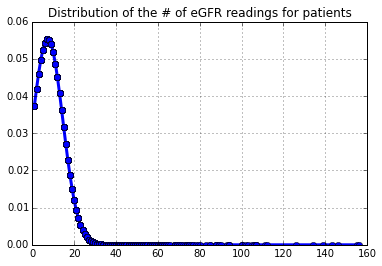

# of patients: 63215
On an average a patient has 7.37337657202 eGFR counts


In [249]:
k = 4

def plot_pdf(data, title):
    data.sort()
    pdf = stats.norm.pdf(data, np.mean(data), np.std(data))
    pyplot.plot(data, pdf, '-o', linewidth=3)
    pyplot.grid()
    pyplot.title(title)
    pyplot.show()

def analyze_patient_records(person_ids, egfr_values, timestamp):
    
    # Try with a smaller subset
#     person_ids = np.array(person_ids[0:20])
#     egfr_values = np.array(egfr_values[0:20])
    
    unique_patients, unique_index, egfr_counts = np.unique(person_ids, return_counts=True, return_index=True)
    
    top_k_egfr = np.argpartition(egfr_counts, -k)[-k:]
    top_k_patients = unique_patients[top_k_egfr]
    
    # Plot distribution of the # of eGFR readings for patients
    plot_pdf(egfr_counts, 'Distribution of the # of eGFR readings for patients')
    
    print '# of patients:', unique_patients.shape[0]
    print 'On an average a patient has', np.average(egfr_counts), 'eGFR counts'
    
    return top_k_egfr, top_k_patients
    

top_k_egfr, top_k_patients = analyze_patient_records(person_ids, egfr, timestamp)

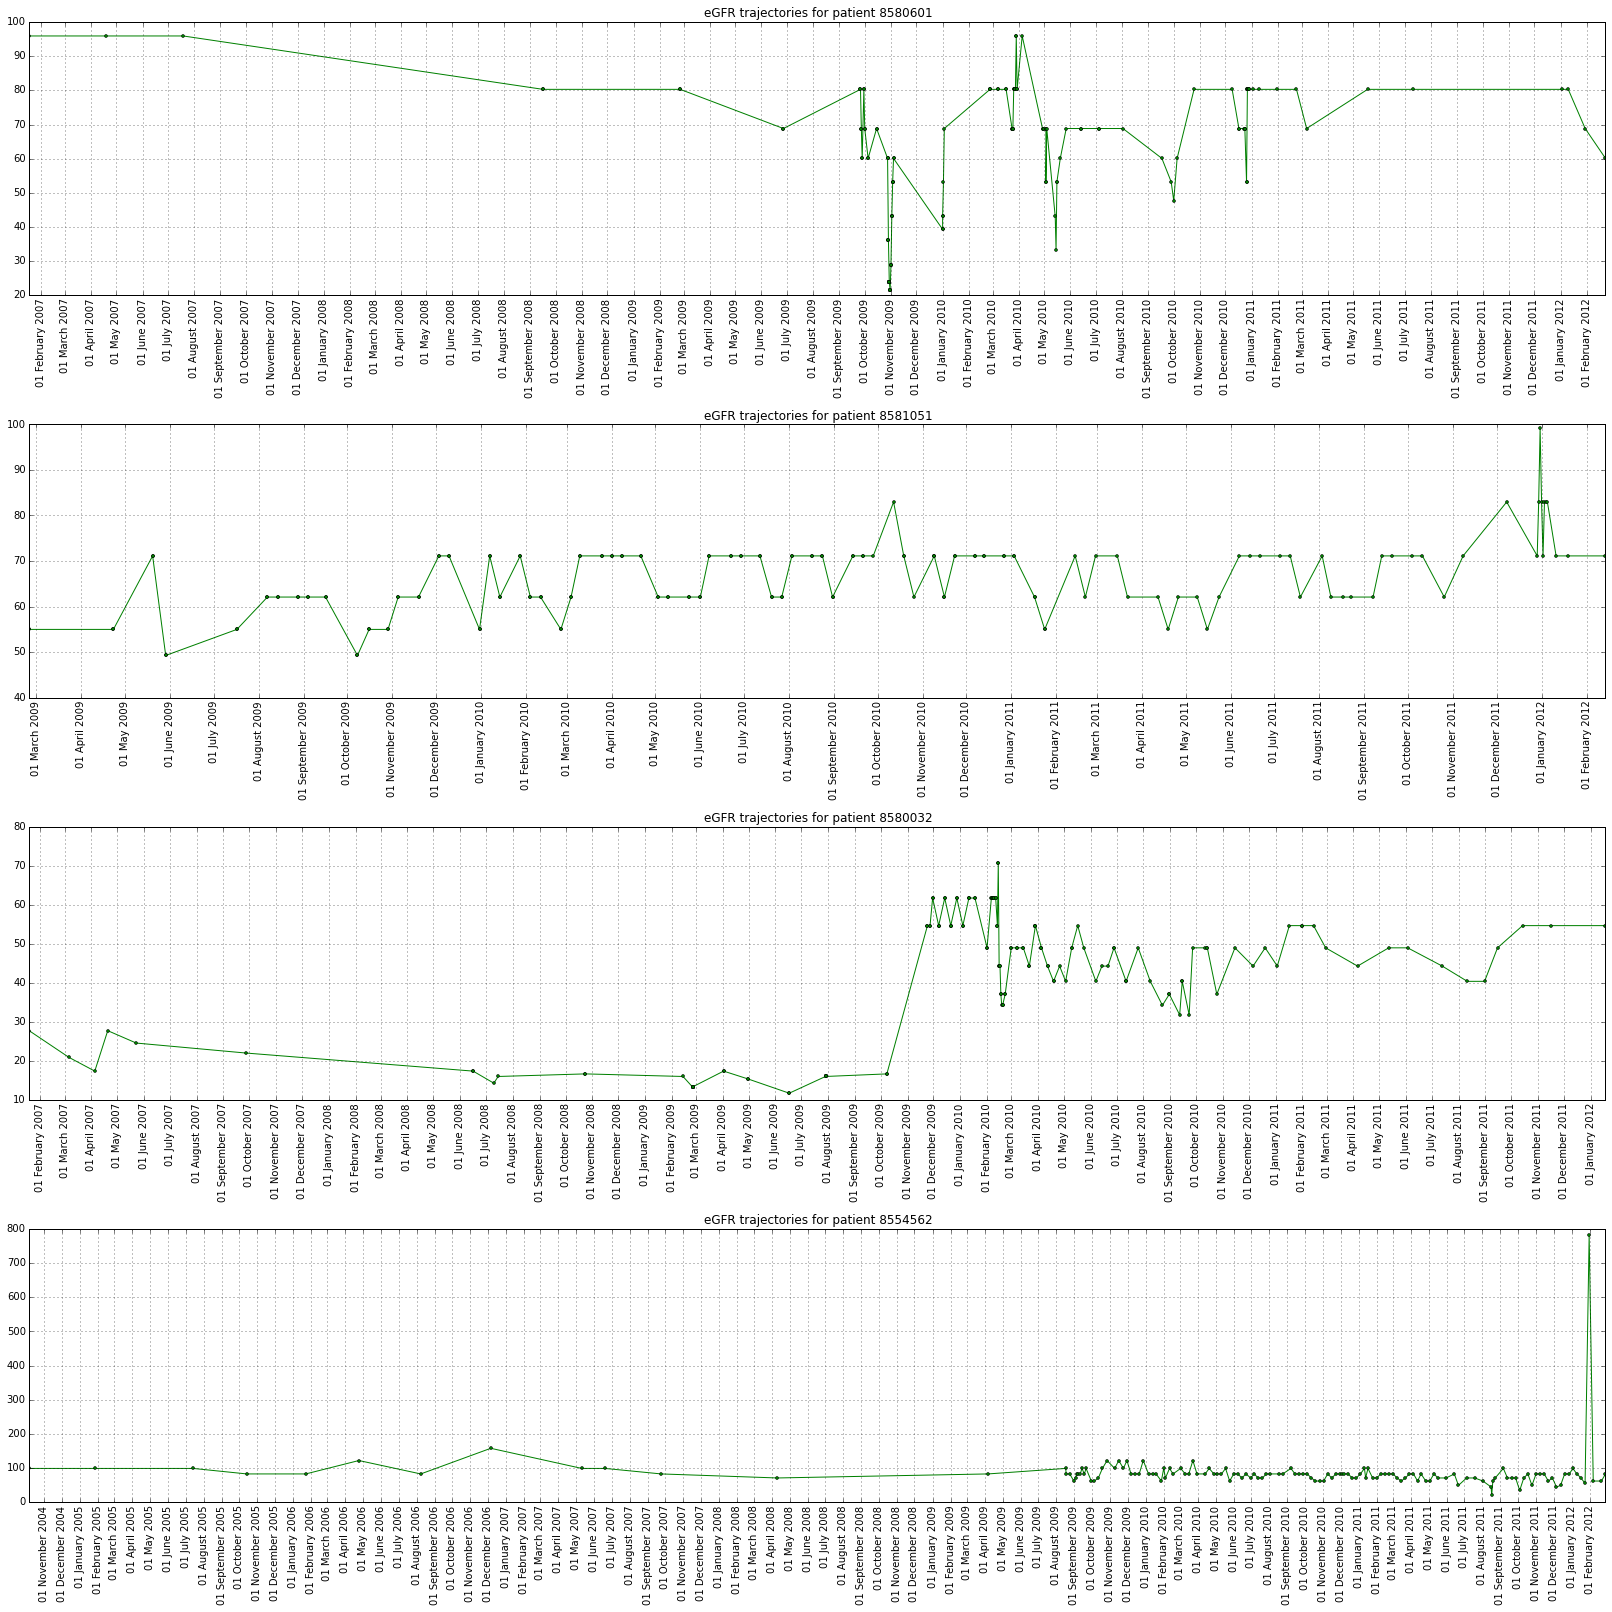

In [250]:
def get_topk_information(top_k_egfr, top_k_patients, all_timestamps, all_egfr_values):
    
    # Remove the time part from the timestamp. We only need the date
    def removeTimeFromTimestamp(s):
        return s[:10]
    all_timestamps = np.vectorize(pyfunc=removeTimeFromTimestamp)(all_timestamps)
    
    # Top k patients = top_k_patients
    # eGFR values of the top k patients = topk_egfr_values
    # Timestamp values of the top k patients = topk_timestamps
    
    topk_egfr_values = []
    topk_timestamps = []
    for i in range(k):
        this_patients_id = top_k_patients[i]
        this_patients_egfr_values = all_egfr_values[np.where(person_ids == this_patients_id)]
        this_patients_timestamps_values = all_timestamps[np.where(person_ids == this_patients_id)]
        topk_egfr_values.append(this_patients_egfr_values)
        topk_timestamps.append(this_patients_timestamps_values)

    # Convert to python's datetime format
    for index, person in enumerate(topk_timestamps):
        topk_timestamps[index] = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in person]
    
    return topk_timestamps, topk_egfr_values

def plot_trajectories(top_k_patients, topk_timestamps, topk_egfr_values):
    
#     figure, axis = plt.subplots()
#     axis.xaxis_date()
    figure = pyplot.figure()
    figure.set_size_inches(22.5, 22.5)
    for i in range(k):
        pyplot.subplot(4,1,i)
        pyplot.plot(topk_timestamps[i], topk_egfr_values[i], '-o', linewidth=1, markersize=3, color='g')
        # Set date-format for the x-axis
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %B %Y'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
#         plt.gcf().autofmt_xdate()
        plt.xticks(rotation=90)
        pyplot.grid()
        pyplot.title('eGFR trajectories for patient ' + str(top_k_patients[i]))
    pyplot.tight_layout()
    
    pyplot.show()


topk_timestamps, topk_egfr_values = get_topk_information(top_k_egfr, top_k_patients, timestamp, egfr)

plot_trajectories(top_k_patients, topk_timestamps, topk_egfr_values)

## Understanding the time gaps in eGFR readings

### We look at the gaps (in days) of the eGFR readings for the top 4 patients

On an average patient 8554562 has gaps of 19.02 days
Mode: 7 with 77 counts.
Variance: 1920.10518746


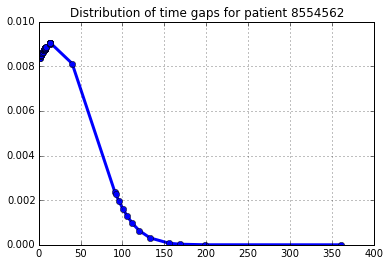

On an average patient 8580601 has gaps of 12.84 days
Mode: 0 with 75 counts.
Variance: 1916.71277051


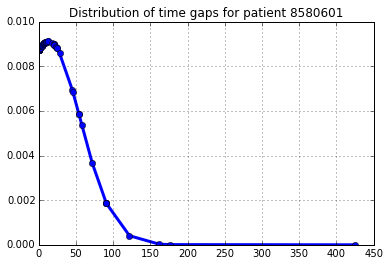

On an average patient 8581051 has gaps of 7.00 days
Mode: 0 with 57 counts.
Variance: 73.0322580645


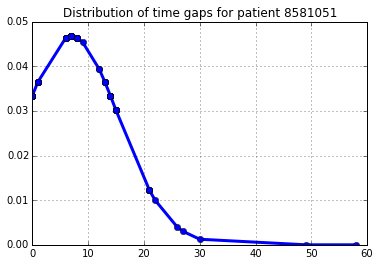

On an average patient 8580032 has gaps of 11.85 days
Mode: 0 with 67 counts.
Variance: 793.893278799


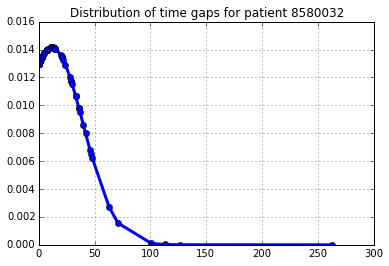

In [251]:
def get_time_gaps_for_patient(dates):
    time_gaps = []
    for i in range(0, len(dates)-1):
        difference_in_dates = dates[i+1] - dates[i]
        time_gaps.append(difference_in_dates.days)
    return time_gaps
    
for i in range(k):
    time_gaps = get_time_gaps_for_patient(topk_timestamps[i])
    time_gaps = np.array(time_gaps)

    print 'On an average patient', top_k_patients[i], 'has gaps of', "{0:.2f}".format(np.average(time_gaps)), 'days'
    mode=scipy.stats.mode(time_gaps)
    print 'Mode:', int(mode[0][0]), 'with', int(mode[1][0]), 'counts.'
    print 'Variance:', np.var(time_gaps)
    plot_pdf(time_gaps, 'Distribution of time gaps for patient ' + str(top_k_patients[i]))

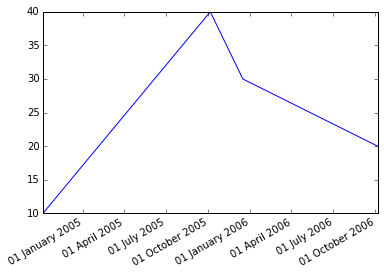

In [252]:
# Experiments here


import datetime as dt

datestr = ["2004-10-06 10:53:00", "2005-10-06 10:53:00", "2005-12-16 10:53:00", "2006-10-06 10:53:00"]
y = [10, 40, 30, 20]

datestr = [d[:10] for d in datestr]

dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in datestr]

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %B %Y'))
plt.gcf().autofmt_xdate()
# plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.plot(dates, y)
